# Time Series Forecasting

<span>This notebook demenstrates my solution to a time series problem posted on Kaggle. In this dataset we have 1 million training records from 1000 stores. We will need to use this information predict the the sale for a test set our 40,000 records. This notebook deals with a regression problem while using a fully connected neuarl network as its model. </span>

**Dataset**

Rossman Dataset: https://www.kaggle.com/c/rossmann-store-sales/overview

### Import Preliminaries

In [17]:
# Import generic data science packages
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Import modules
import datetime
import keras
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import missingno as msno
import numpy as np
import pandas as pd
import sqlalchemy
import sklearn
import seaborn as sns
import warnings

from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

# Set pandas options
pd.set_option('max_columns',1000)
pd.set_option('max_rows',30)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set plotting options
mpl.rcParams['figure.figsize'] = (8.0, 7.0)

### Import Data

In [2]:
# Set your local database parameters 
db_username = 'root'
db_password = 'mypassword'
host = '127.0.0.1'
port = '3306'
db_name = 'rossman'

# Create a MySQLEngine
engine = sqlalchemy.create_engine('mysql+mysqldb://'+db_username+':'+db_password+'@\
'+host+':'+port+'/'+db_name)

# Connect to database
engine.connect();

# Import data from SQL
train_df = pd.read_sql(""" SELECT * FROM train""", engine,
                      parse_dates=['Date'],
                      ).dropna(how='any', axis=0)
test_df = pd.read_sql(""" SELECT * FROM test""", engine,
                     index_col='Id', parse_dates=['Date']
                     ).dropna(how='any', axis=0)
stores = pd.read_sql(""" SELECT * FROM store""", engine,
                     ).dropna(how='any', axis=0)

# Rename Sales column to Target
train_df.rename(columns={'Sales':'target'}, inplace=True)

# Replace Empty string in store dataframe with Null Values
for col in stores:
    stores[col] = stores[col].replace('',np.nan)

# Down Sample Dataset
train_df = train_df.sample(10_000)
test_df = test_df.sample(10_000)
    
# View Store Dataframe
stores.head(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.000,9,2008,0,NaN,NaN,NaN
1,2,a,a,570.000,11,2007,1,13,2010,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.000,12,2006,1,14,2011,"Jan,Apr,Jul,Oct"
3,4,c,c,620.000,9,2009,0,NaN,NaN,NaN
4,5,a,a,29910.000,4,2015,0,NaN,NaN,NaN


In [3]:
# View head of the dataframe
test_df.head(10)

,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
Id,,,,,,,
4544,342,6,2015-09-12,1.000,0,0,0
30516,719,4,2015-08-13,1.000,0,0,1
37249,570,3,2015-08-05,1.000,1,0,1
7227,497,3,2015-09-09,1.000,0,0,0
20457,1000,2,2015-08-25,1.000,0,0,1
26951,538,1,2015-08-17,1.000,1,0,1
22579,418,6,2015-08-22,1.000,0,0,0
28718,605,6,2015-08-15,1.000,0,0,0
8992,558,1,2015-09-07,1.000,0,0,0


In [4]:
# View head of the dataframe
train_df.head(10)

,Store,DayOfWeek,Date,target,Customers,Open,Promo,StateHoliday,SchoolHoliday
372304,366,7,2014-07-27,0,0,0,0,0,0
765229,996,4,2013-07-25,4572,573,1,0,0,1
709610,947,5,2013-09-13,9524,1201,1,1,0,0
750769,1031,3,2013-08-07,3522,336,1,0,0,1
691889,1066,7,2013-09-29,0,0,0,0,0,0
191193,180,3,2015-02-04,7281,829,1,1,0,0
547743,740,1,2014-02-10,4816,372,1,0,0,0
246560,179,3,2014-12-10,6277,859,1,0,0,0
339401,156,7,2014-08-31,0,0,0,0,0,0
897472,205,5,2013-03-22,7352,939,1,1,0,0


### Data Completness

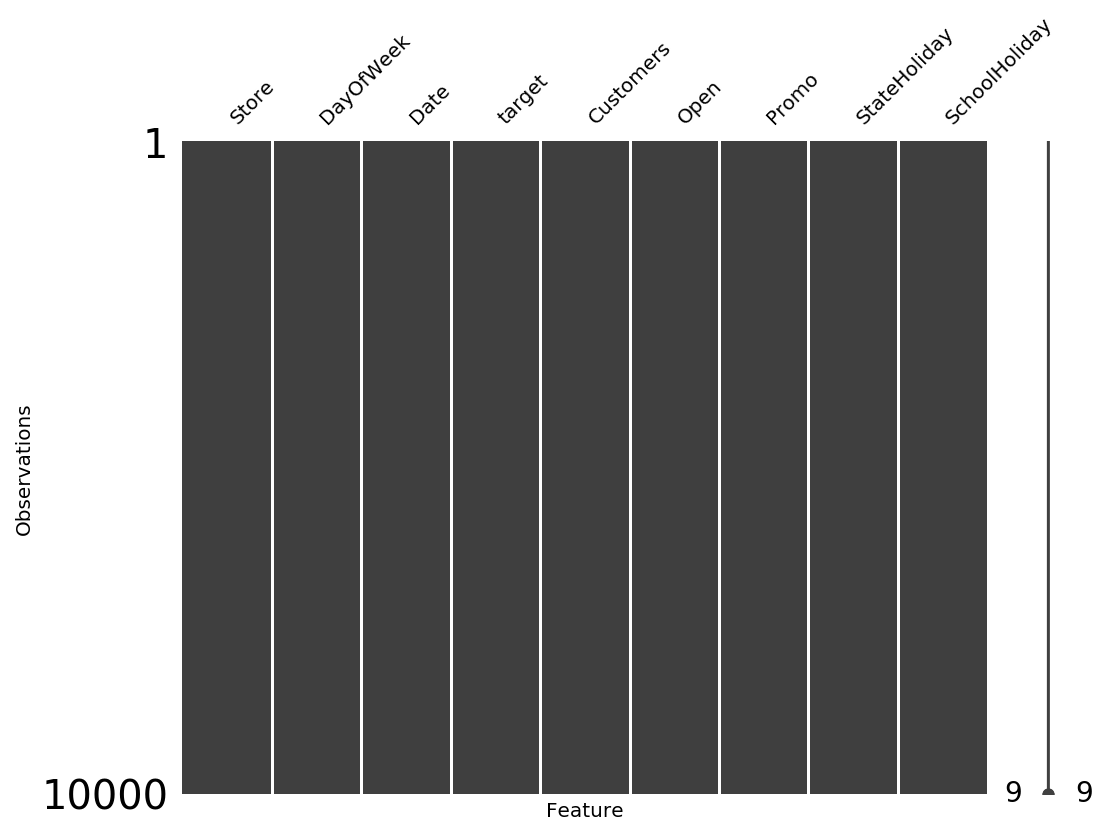

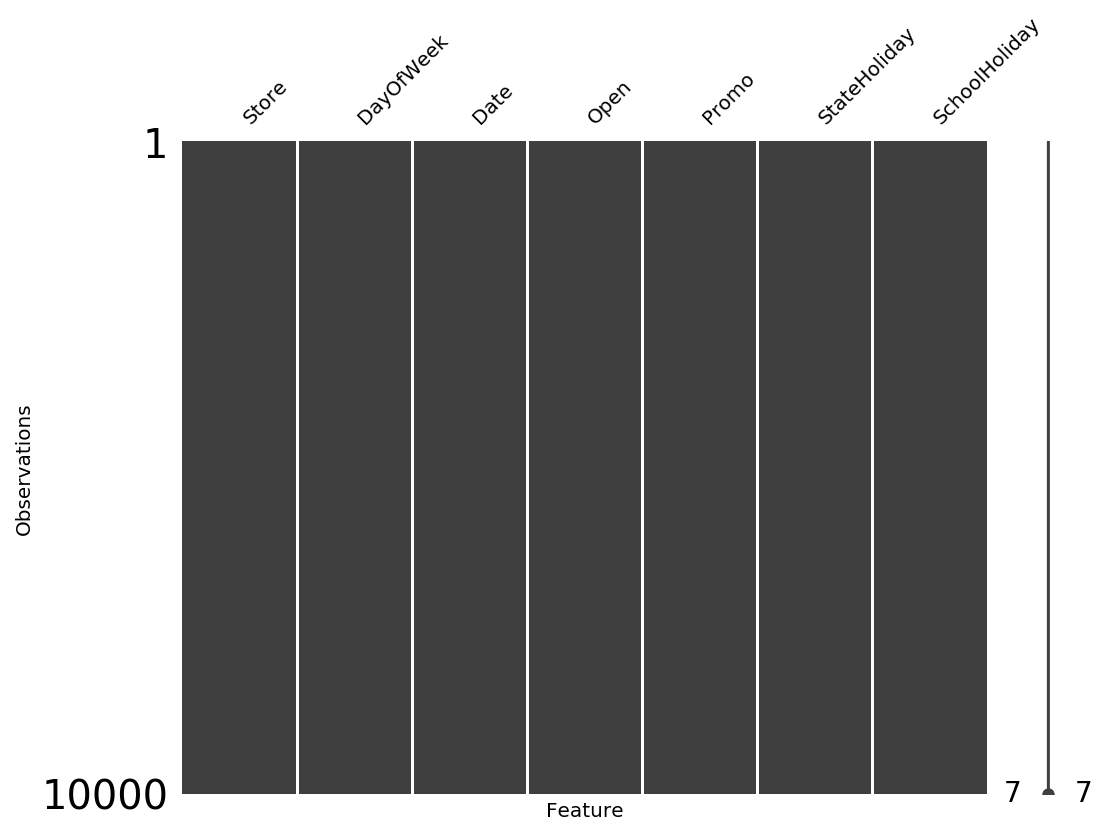

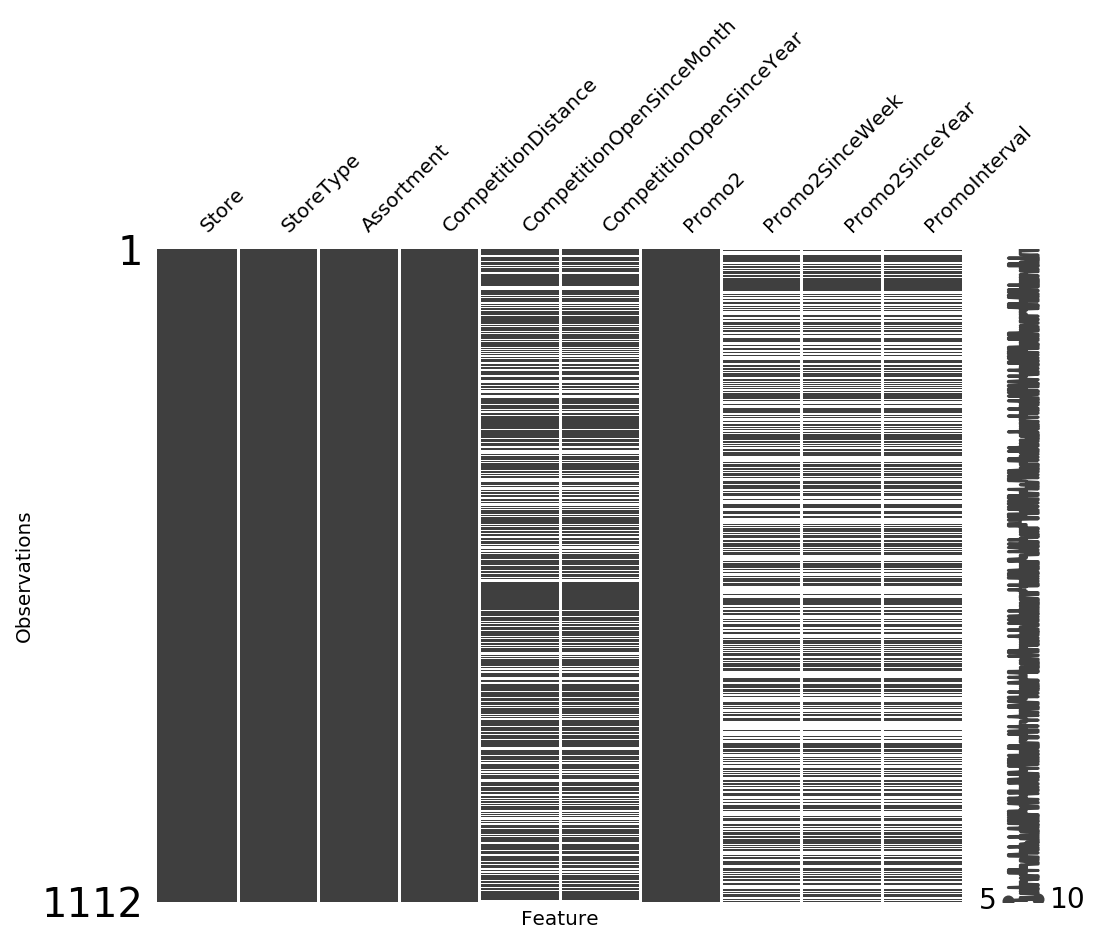

In [5]:
msno.matrix(train_df,  figsize=(8,6), fontsize=10);
plt.xlabel('Feature')
plt.ylabel('Observations');

msno.matrix(test_df,  figsize=(8,6), fontsize=10);
plt.xlabel('Feature')
plt.ylabel('Observations');

msno.matrix(stores,  figsize=(8,6), fontsize=10);
plt.xlabel('Feature')
plt.ylabel('Observations');

### Data Overview

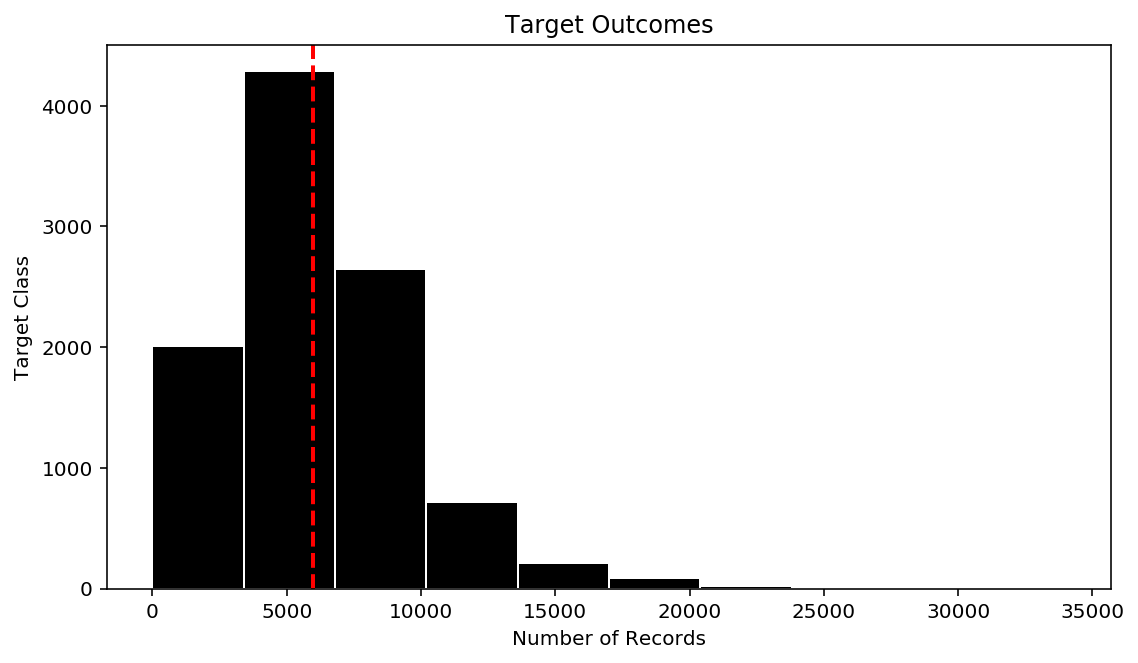

In [6]:
# Plot the distribution of target classes
train_df.target.plot.hist(figsize=(9,5),color='black', edgecolor='white')
plt.axvline(train_df.target.mean(), color='r', linestyle='dashed', 
            linewidth=2);
plt.title('Target Outcomes')
plt.ylabel('Target Class')
plt.xlabel('Number of Records');

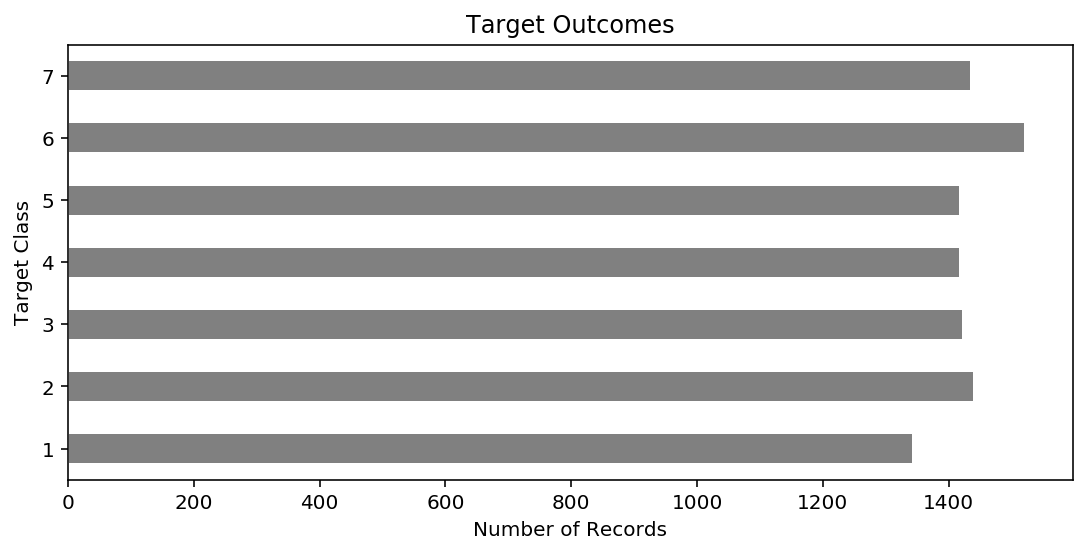

In [7]:
# Plot a barplot of the target clasees in our training set
# (1 = posinous, 0 = eatable by humans)
train_df.DayOfWeek.value_counts().sort_index().plot.barh(
       figsize = (9,4),
       grid=False, 
       color='grey', 
       width=0.5, edgecolor='w')
plt.title('Target Outcomes')
plt.ylabel('Target Class')
plt.xlabel('Number of Records');

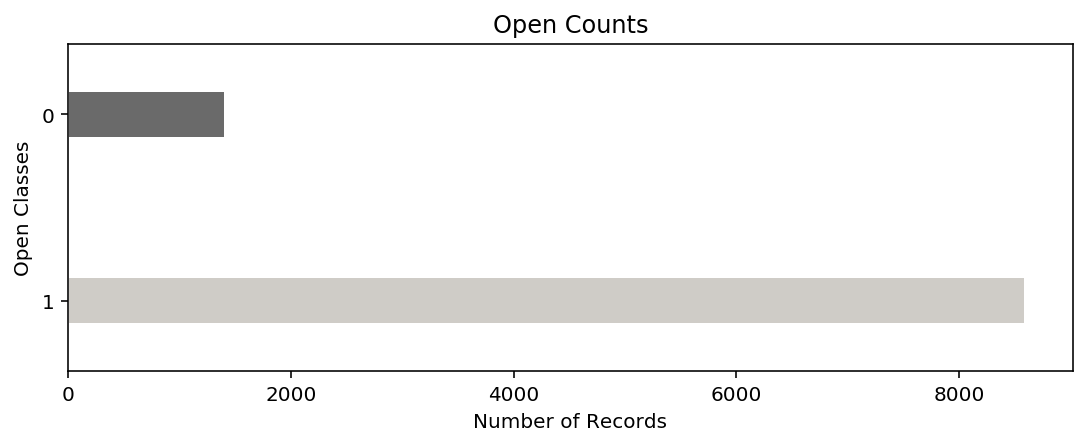

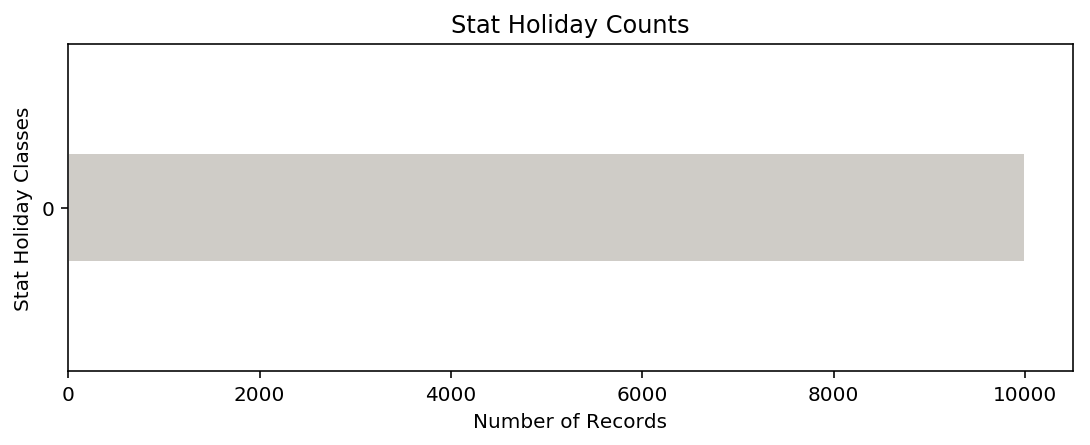

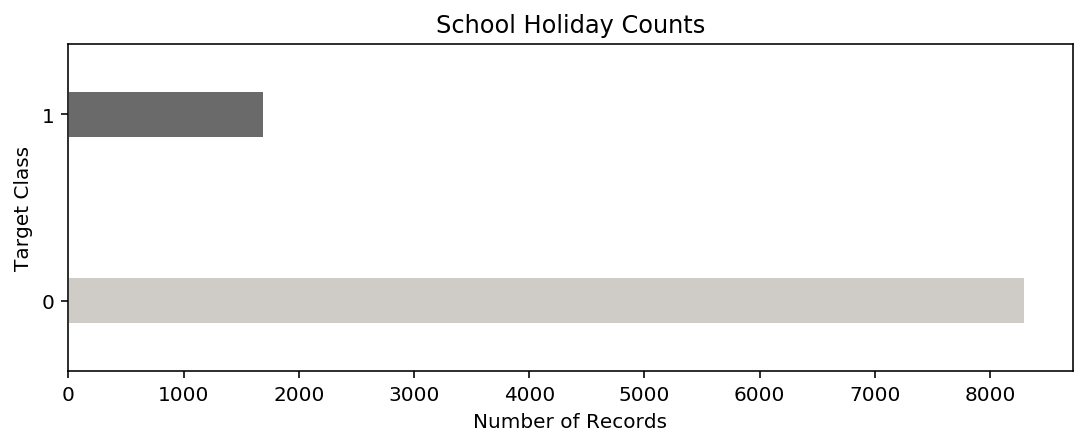

In [8]:
# Plot a Open
plt.figure()
train_df.Open.value_counts().plot.barh(figsize=(9,3),
                                       grid=False, 
                                       color=['#CFCCC7','#6A6A6A','#000000'], 
                                       width=0.25,edgecolor='w')
plt.title('Open Counts')
plt.ylabel('Open Classes')
plt.xlabel('Number of Records');

plt.figure()
train_df.StateHoliday.value_counts().plot.barh(figsize=(9,3),
                                           grid=False, 
                                           color=['#CFCCC7','#6A6A6A','#000000'], 
                                           width=0.25,edgecolor='w')
plt.title('Stat Holiday Counts')
plt.ylabel('Stat Holiday Classes')
plt.xlabel('Number of Records');


# Plot a Open
plt.figure()
train_df.SchoolHoliday.value_counts().plot.barh(figsize=(9,3),
                                           grid=False, 
                                           color=['#CFCCC7','#6A6A6A','#000000'], 
                                           width=0.25,edgecolor='w')
plt.title('School Holiday Counts')
plt.ylabel('Target Class')
plt.xlabel('Number of Records');

### Data Incosistencies

In [9]:
print('Training Dataset:', train_df.columns, '\n')
print('Testing Dataset:', test_df.columns)

Training Dataset: Index(['Store', 'DayOfWeek', 'Date', 'target', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object') 

Testing Dataset: Index(['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday'],
      dtype='object')


We can see that training dataset has a column that is not present in our Testing Set. Therefore let's map the customers count to the storse dataset than merge the total customer counts back into the main testing and training dataframes in the next cells.

In [10]:
customers_df = train_df[['Store','Customers']]
customers_df = customers_df.groupby('Store')['Customers'].sum().to_frame()
customers_df.rename(columns={'Customers':'Lifetime Customers'}, inplace=True)
train_df = train_df.drop('Customers', axis=1)
customers_df.head(10)

,Lifetime Customers
Store,
1,2594
2,3120
3,5299
4,10699
5,4889
6,5307
7,4785
8,5678
9,5857


### Data Cleaning

In [11]:
# Fill Null Valuse

train_fdf = train_df.copy()
test_fdf = test_df.copy()
store_fdf = stores.copy()

train_fdf = train_fdf.merge(stores, how='left', on='Store')
test_fdf = test_fdf.merge(stores, how='left', on='Store')

# Null Values From Merge
train_fdf.CompetitionOpenSinceMonth.fillna(-1, inplace=True)
train_fdf.CompetitionOpenSinceYear.fillna(datetime.datetime.now().year + 1, inplace=True)
train_fdf.Promo2.fillna(-1, inplace=True)
train_fdf.Promo2SinceWeek.fillna(-1, inplace=True)
train_fdf.Promo2SinceYear.fillna(datetime.datetime.now().year + 1, inplace=True)
train_fdf.PromoInterval.fillna('Unknown', inplace=True)

# Values After Merge
train_fdf.Assortment.fillna('Unknown', inplace=True)
train_fdf.StoreType.fillna('Uknown', inplace=True)
train_fdf.CompetitionDistance.fillna(train_fdf.CompetitionDistance.mean(), inplace =True)

train_fdf.isnull().sum()

Store                        0
DayOfWeek                    0
Date                         0
target                       0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [12]:
# Null Values From Merge
test_fdf.CompetitionOpenSinceMonth.fillna(-1, inplace=True)
test_fdf.CompetitionOpenSinceYear.fillna(datetime.datetime.now().year + 1, inplace=True)
test_fdf.Promo2.fillna(-1, inplace=True)
test_fdf.Promo2SinceWeek.fillna(-1, inplace=True)
test_fdf.Promo2SinceYear.fillna(datetime.datetime.now().year + 1, inplace=True)
test_fdf.PromoInterval.fillna('Unknown', inplace=True)

# Values After Merge
test_fdf.Assortment.fillna('Unknown', inplace=True)
test_fdf.StoreType.fillna('Uknown', inplace=True)
test_fdf.CompetitionDistance.fillna(train_fdf.CompetitionDistance.mean(), inplace =True)

test_fdf.isnull().sum()

Store                        0
DayOfWeek                    0
Date                         0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

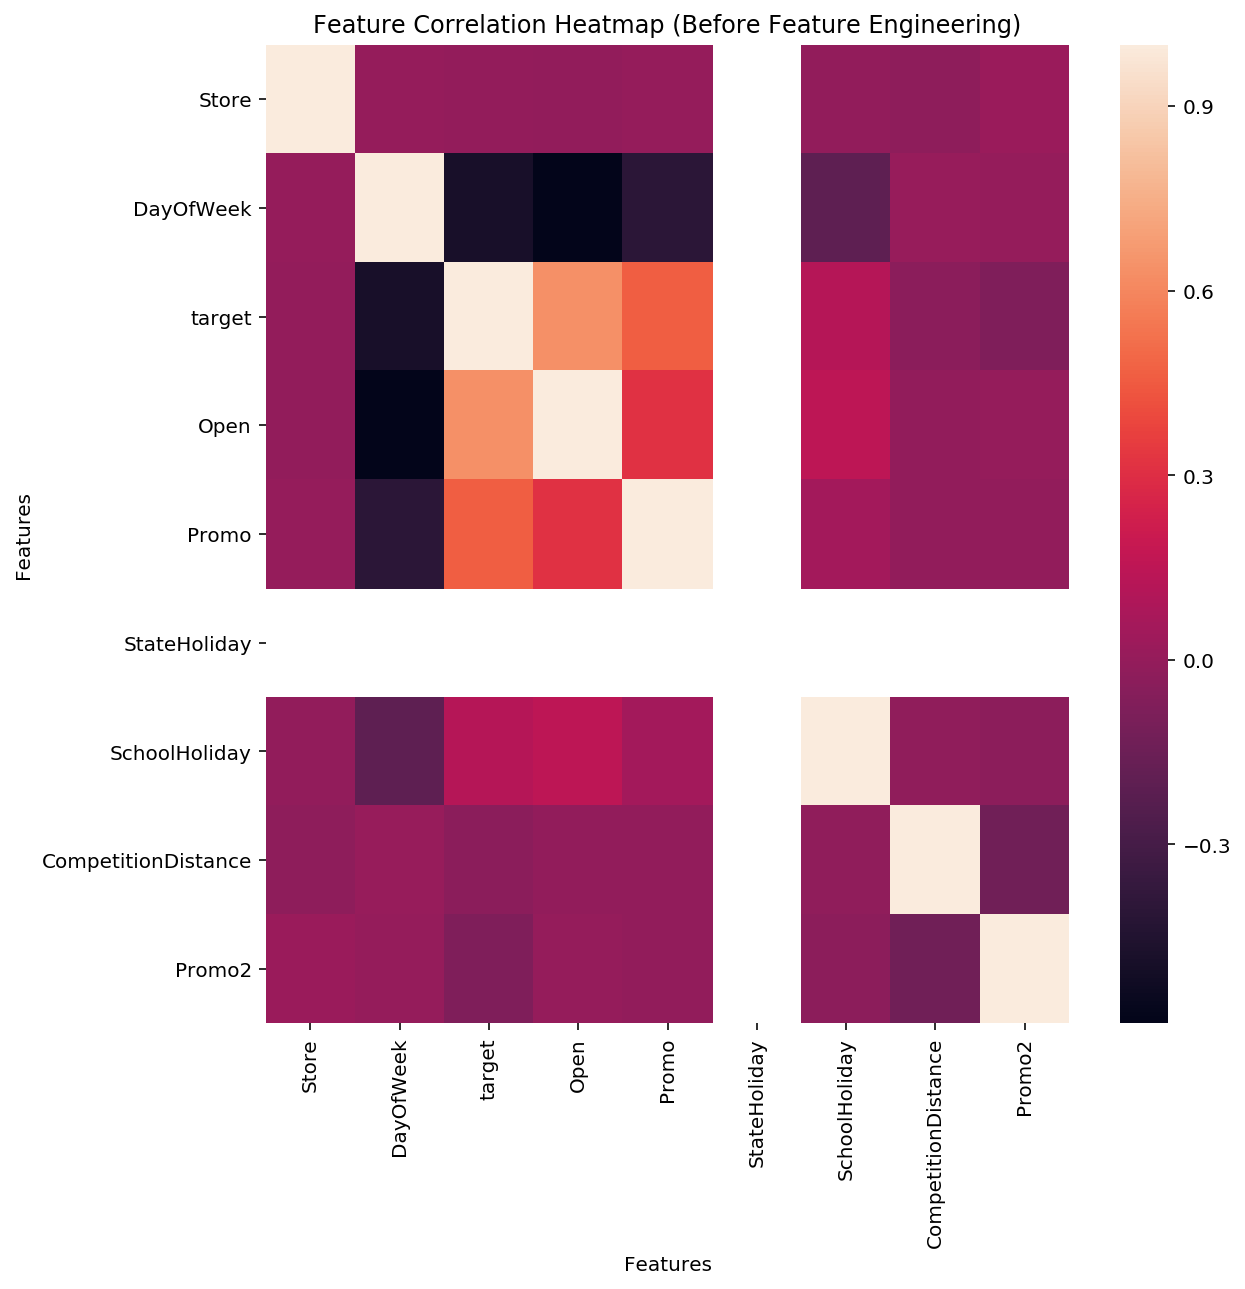

In [13]:
plt.figure(figsize=(9,9))
sns.heatmap(train_fdf.corr())
plt.title('Feature Correlation Heatmap (Before Feature Engineering)')
plt.xlabel('Features')
plt.ylabel('Features');

### Feature Engineering

In [14]:
# Append Customer Information
train_fdf = train_fdf.merge(customers_df, how='left', on='Store')
test_fdf = test_fdf.merge(customers_df, how='left', on='Store')


# One Hot Encoding Train Non-Ordinal Feature
train_fdf = pd.get_dummies(train_fdf, drop_first=True,
               columns=['Assortment','Store','StoreType','Promo2',
                        'Promo2SinceYear','PromoInterval'])

# One Hot Encoding Test Non-Ordinal Feature
test_fdf = pd.get_dummies(test_fdf, drop_first=True,
               columns=['Assortment','Store','StoreType','Promo2',
                        'Promo2SinceYear','PromoInterval'])

# Expand Train DateTime Feature
train_fdf['Year'] = train_fdf['Date'].dt.year
train_fdf['Day'] = train_fdf['Date'].dt.day
train_fdf['Montah']= train_fdf['Date'].dt.month
train_fdf.drop('Date', axis=1 ,inplace=True)

# Expand Test DateTime Feature
test_fdf['Year'] = test_fdf['Date'].dt.year
test_fdf['Day'] = test_fdf['Date'].dt.day
test_fdf['Month']= test_fdf['Date'].dt.month
test_fdf.drop('Date', axis=1 ,inplace=True)

# Change the Opent Store Year into a Year Ago
train_fdf.CompetitionOpenSinceYear = (train_fdf.CompetitionOpenSinceYear.astype(int) 
                                      - datetime.datetime.now().year)
test_fdf.CompetitionOpenSinceYear = (test_fdf.CompetitionOpenSinceYear.astype(int) 
                                      - datetime.datetime.now().year)
# Drop StateHoliday Feature
train_df.drop('StateHoliday', axis=1, inplace=True )
test_df.drop('StateHoliday', axis=1, inplace=True)

### Encoding + Split Data

In [15]:
# Clean us some remaining object dtypes into ints
for df in [train_fdf, test_fdf]:
    for col in df.select_dtypes(include='object'):
        df[col] = df[col].astype(int)

# Target Values
y = train_fdf.target
train_fdf.drop('target', axis=1, inplace=True)
        
        
# Data Frame to Spare Matrix
X = train_fdf
#X = csr_matrix(train_fdf.values)
#test_x = csr_matrix(test_fdf.values)


# Train Test Split into a training and validation set
train_x, val_x, train_y, val_y = train_test_split(X,y, shuffle=False)

# Decompose our dataset downt to 10 PCA components
decomposer = PCA(n_components=10)
train_x = decomposer.fit_transform(train_x)
val_x = decomposer.transform(val_x)

# Scaler
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
val_x = scaler.transform(val_x)

print('Dataframe Size:', train_fdf.size)
#print('Sparse Matrix Size:', train_x.data.nbytes)

Dataframe Size: 11460000


### Benchmark Model Pipelines

In [57]:
# Import models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from keras import models
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier

In [68]:
# Linear Regression Pipeline 
lr_pipeline = make_pipeline(PCA(n_components=10),StandardScaler(), LinearRegression())
lr_scores = cross_val_score(lr_pipeline, X, y, cv=kfold, scoring='neg_mean_absolute_error')
print(f'Linear Regression Cross Validation Score - Mean Absolute Erorr: {lr_scores.mean():.5f}')

Linear Regression Cross Validation Score MSE: -2170.63271


In [69]:
# Linear Regression Pipeline 
rfr_pipeline = make_pipeline(PCA(n_components=10),StandardScaler(), RandomForestRegressor())
rfr_scores = cross_val_score(rfr_pipeline, X, y, cv=kfold, scoring='neg_mean_absolute_error')
print(f'Linear Regression Cross Validation Score - Mean Absolute Erorr: {rfr_scores.mean():.5f}')

Linear Regression Cross Validation Score MSE: -1371.60441


### Densely Connected Neural Nework

In [18]:
# Dense Neural Network
def create_ds_model():
    model = models.Sequential()
    model.add(layers.Dense(128, activation='relu', input_shape=(train_x.shape[1],)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='neg_mean_absolute_error', metrics=['mae'])
    return model

ds_model = KerasClassifier(build_fn=create_ds_model, epochs=50, batch_size=10, verbose=1)

# Linear Regression Pipeline 
ds_pipeline = make_pipeline(PCA(n_components=10),StandardScaler(), ds_model)
ds_scores = cross_val_score(ds_pipeline, X, y, cv=kfold, scoring='neg_mean_absolute_error')
print(f'Densly Connected Cross Validation Score -  Mean Absolute Error : {ds_scores.mean():.5f}')

NameError: name 'KerasClassifier' is not defined